In [1]:
import torch
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math
import sys
sys.path.append('../')

import DRLPDE.neuralnets as neuralnets
import importlib

mpl.rcParams['figure.dpi'] = 600
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['font.size'] = 8

In [2]:
test = 'compare'

with open('../experiments/' + test + '_parameters.pickle', 'rb') as f:
    parameters = pickle.load(f)

with open('../experiments/'  + test + '_losses.pickle', 'rb') as f:
    losses = pickle.load(f)

with open('../experiments/'  + test + '_errors.pickle', 'rb') as f:
    errors = pickle.load(f)

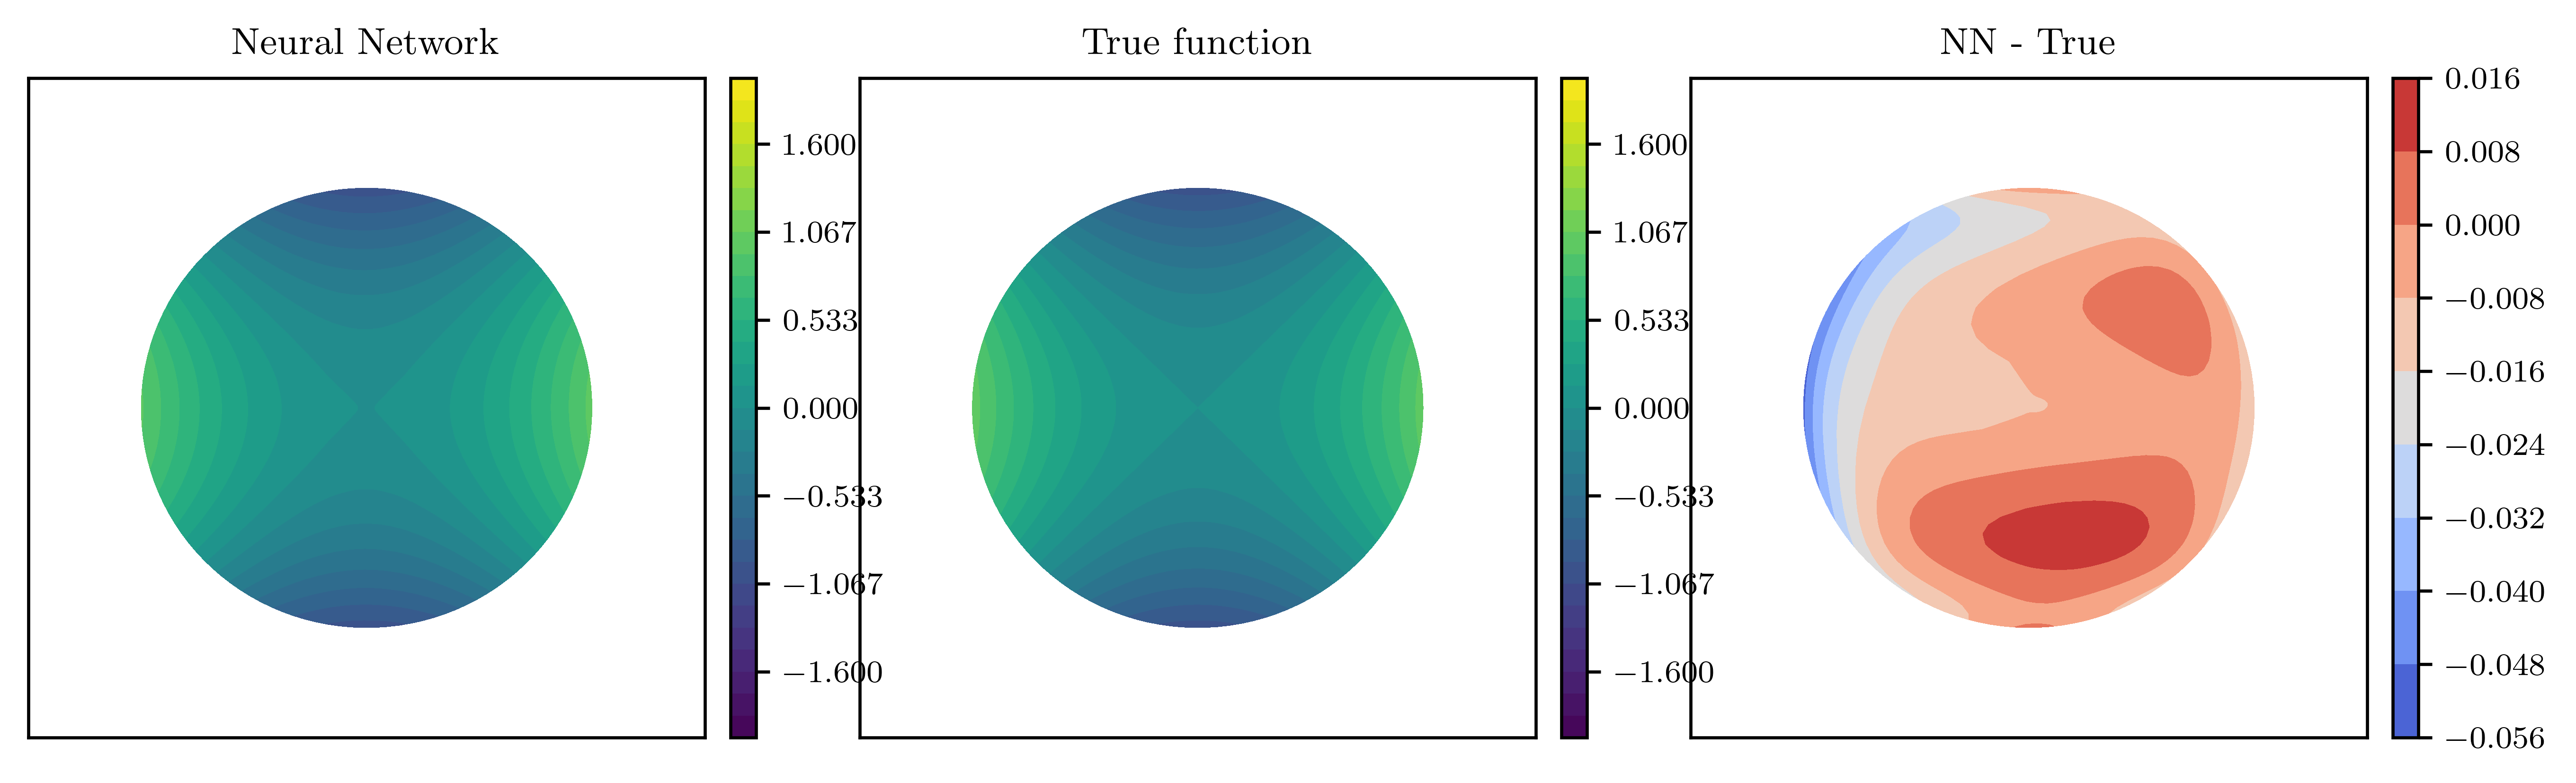

In [7]:
problem = importlib.import_module(".deepxde", package='examples')

input_dim = [problem.x_dim, problem.t_dim, problem.hyper_dim]
output_dim = problem.output_dim

with open('../experiments/' + test + '_parameters.pickle', 'rb') as f:
    parameters = pickle.load(f)

if parameters['neuralnetwork'] == 'FeedForward':
    MyNeuralNetwork = neuralnets.FeedForwardNN
elif parameters['neuralnetwork'] == 'Incompressible':
    MyNeuralNetwork = neuralnets.IncompressibleNN
elif parameters['neuralnetwork'] == 'ResNet':
    MyNeuralNetwork = neuralnets.ResNetNN

nn_size = parameters['nn_size']

model = MyNeuralNetwork(input_dim, output_dim, **nn_size)
model.load_state_dict(torch.load("../savedmodels/" + test + ".pt"))

true_fun = problem.true_fun

num_th = 120
num_r = 20

th = torch.linspace(0,2*math.pi, num_th)
r = torch.zeros(num_r, num_th)
for ii in range(num_th):
    r[:,ii] = torch.sqrt( torch.linspace( 0, 1, num_r) )
r = r.reshape(-1)

rth = torch.stack((r, th.repeat(num_r)), dim=1)
X = torch.stack( (rth[:,0]*torch.cos( rth[:,1] ), rth[:,0]*torch.sin( rth[:,1])), dim=1)
#X = X[num_th-1:,:]
#size = num_th*(num_r-1) + 1 

Y = model(X).detach().reshape(num_r, num_th).numpy()
Ytrue = true_fun(X).detach().reshape(num_r, num_th).numpy()

Xplot = X[:,0].detach().reshape(num_r, num_th).numpy()
Yplot = X[:,1].detach().reshape(num_r, num_th).numpy()

levels = np.linspace(-2, 2, 31)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[9,3])

plt.tight_layout(pad=2.0)

ax[0].set_title('Neural Network')

ax[0].set_xlim(-1.5, 1.5)
ax[0].set_ylim(-1.5, 1.5)
contour0 = ax[0].contourf( Xplot, Yplot, Y, levels=levels, cmap=plt.cm.viridis)
ax[0].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)
colorbar0_param = fig.add_axes(
    [ax[0].get_position().x1 + 0.01,
     ax[0].get_position().y0,
     0.01,
     ax[0].get_position().height])
colorbar0 = plt.colorbar(contour0, cax = colorbar0_param)

ax[1].set_xlim(-1.5, 1.5)
ax[1].set_ylim(-1.5, 1.5)
ax[1].set_title('True function')
contour1 = ax[1].contourf( Xplot, Yplot, Ytrue, levels=levels, cmap=plt.cm.viridis)
ax[1].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)
colorbar1_param = fig.add_axes(
    [ax[1].get_position().x1 + 0.01,
     ax[1].get_position().y0,
     0.01,
     ax[1].get_position().height])
colorbar1 = plt.colorbar(contour1, cax = colorbar1_param)

ax[2].set_xlim(-1.5, 1.5)
ax[2].set_ylim(-1.5, 1.5)
ax[2].set_title('NN - True')
contour2 = ax[2].contourf( Xplot, Yplot, Y - Ytrue, cmap=plt.cm.coolwarm)
ax[2].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)
colorbar2_param = fig.add_axes(
    [ax[2].get_position().x1 + 0.01,
     ax[2].get_position().y0,
     0.01,
     ax[2].get_position().height])
colorbar2 = plt.colorbar(contour2, cax = colorbar2_param)



In [4]:
steps = range(int(parameters['trainingsteps']))
L2loss = losses[:,:,0]
Linfloss = losses[:,:,1]
L2error = np.sqrt(errors[:,:,0])
Linferror = np.sqrt(np.amax(errors[-1,:,1]))

print('Interior L2 error = {:.4f}'.format(L2error[-1,0]))
print('Boundary L2 error = {:.4f}'.format(L2error[-1,1]))
print('Linf error = {:.4f}'.format(Linferror))


Interior L2 error = 0.0224
Boundary L2 error = 0.0624
Linf error = 0.0499


Text(0.5, 149.29543792483912, 'number of steps')

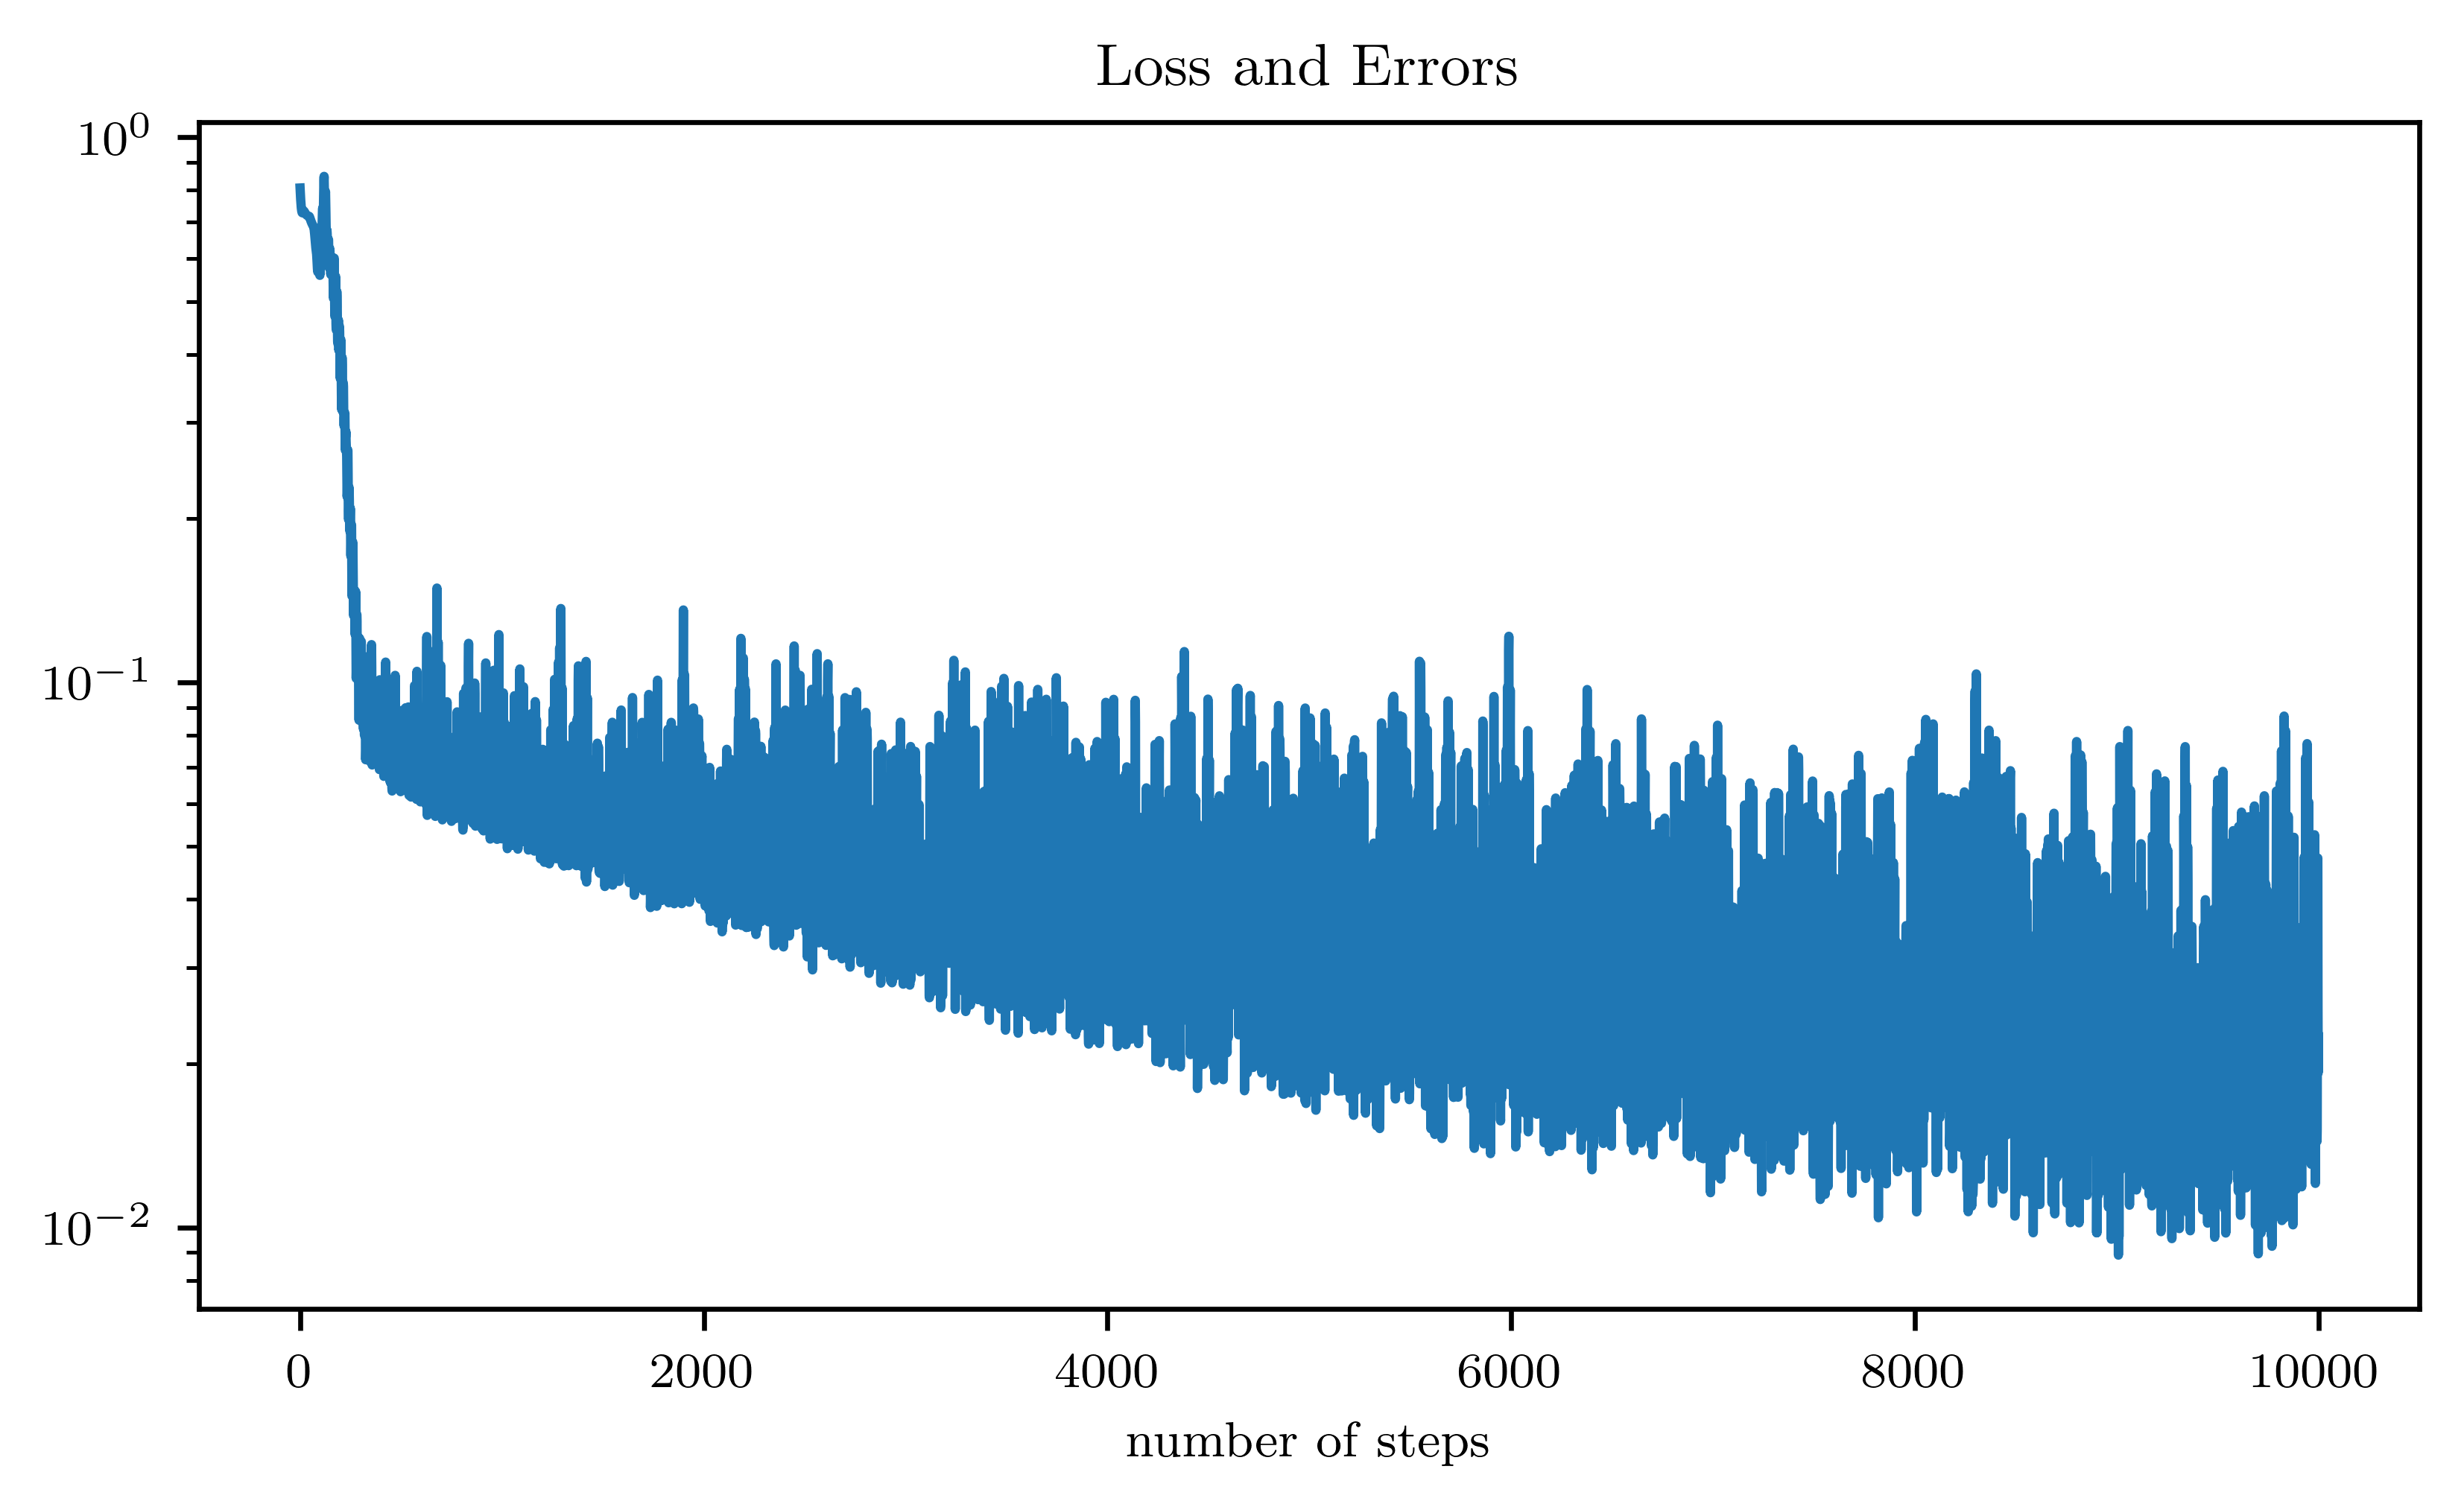

In [8]:
steps = int(parameters['trainingsteps'])
L2loss = losses[:,:,0]
Linfloss = np.sqrt(losses[:,:,1])
L2error = np.sqrt(errors[:,:,0])
Linferror = np.sqrt(np.amax(errors[:,:,1], axis=1))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[6.4, 4])

plt.tight_layout(pad=5.0)

ax.set_title('Loss and Errors')

#ax.semilogy(range(steps), np.sqrt(L2loss[:,0]))
#ax.semilogy(range(steps), np.sqrt(L2loss[:,1]))
#ax.semilogy(range(steps), np.sqrt(Linfloss[:,0]))}
ax.semilogy(range(steps+1), L2error[:,0])
#ax.semilogy(range(steps+1), Linferror)
#ax.legend(['Interior L2 loss', 'Interior Linf loss', 'Interior L2 error', 'Interior Linf error'])
ax.set_xlabel('number of steps')

#ax[1].set_title('Comparing L2 loss and L2 error')
#ax[1].semilogy(steps, np.abs( 5.1148*L2loss - L2error) )